# Check Bounding Boxex NIH

In [32]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import patches
from matplotlib.collections import PatchCollection
#import matplotlib
from PIL import Image, ImageDraw
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu
from shapely.geometry.polygon import Polygon as Polygon_shapley
# from multiprocessing import Pool
import multiprocessing
import time
import random
import pickle
import png
from scipy.spatial import ConvexHull
import bbox_visualizer as bbv
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder (see the terminal comand below) e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [33]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT", "Img"), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[::2], list_locations[1::2]))
            df = df.append( {'Patient no - Cell no': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                'Number of points': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [34]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])

    if annotation == 'Point':
        x = position[0][0] 
        y = position[0][1] 
        cv2.circle(img, position[0], 1, colour, point_size)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon_shapley(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [35]:
txt_list = get_txt('../NIH-NLM-ThinBloodSmearsPf')
print(len(txt_list))

965


**The following operation takes a while lean back and get a coffee**

In [36]:
# df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
# start_time = time.time()  

# # Repeats the compute intensive operation on all available cores
# pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
# pool.map_async(txt_to_df, txt_list, callback = collect_results)
# pool.close()
# pool.join()

# # Converts list of lists to a data frame
# print(df.shape)
# print("--- %s seconds ---" % (time.time() - start_time))

(196934, 9)
--- 145.65978479385376 seconds ---


In [37]:
# df.reset_index(drop=True, inplace = True)
# pickle_labels = open('labels.pkl', 'wb') 
# pickle.dump(df, pickle_labels)

In [38]:
df = pd.read_pickle('labels.pkl')

In [39]:
df

Patient no - Cell no         cell     comment annotation_type  \
0                       1-1  Parasitized  No_Comment           Point   
1                       1-2   Uninfected  No_Comment           Point   
2                       1-3   Uninfected  No_Comment           Point   
3                       1-4   Uninfected  No_Comment           Point   
4                       1-5   Uninfected  No_Comment           Point   
...                     ...          ...         ...             ...   
196929                4-167  Parasitized  No_comment         Polygon   
196930                4-168  Parasitized  No_comment         Polygon   
196931                4-169  Parasitized  No_comment         Polygon   
196932                4-170  Parasitized  No_comment         Polygon   
196933                4-171  Parasitized  No_comment         Polygon   

       Number of points                                           position  \
0                     1                                     [(2470, 1302)]   
1                     1                                      [(1598, 944)]   
2                     1                                      [(1756, 987)]   
3                     1                                      [(2000, 895)]   
4                     1                                     [(1938, 1006)]   
...                 ...                                                ...   
196929               25  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930               21  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931               20  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932               20  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933               17  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
...                                                   ...  
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  

[196934 rows x 9 columns]

In [55]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected          188711
Parasitized           7952
White_Blood_Cell       271
Name: cell, dtype: int64

In [56]:
df_points = df[df['annotation_type'] == 'Point']
df_points.groupby(['filename']).count()['cell'].mean()

203.3375

In [57]:
# df['position_len'] = df['position'].apply(lambda x: len(x))
# short_polygon = df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] < 3)] 
# short_polygon.to_csv('short_polygon.csv', index = False)

In [58]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                             bbx  
195475  [3575, 1304, 3727, 1432]  
195476  [1441, 1202, 1568, 1307]  
195477  [2856, 1398, 2960, 1541]  
195478  [2982, 1460, 3091, 1578]  
195479  [3043, 1651, 3169, 1788]  
...                          ...  
195679  [3289, 1194, 3419, 1331]  
195680  [3346, 1375, 3496, 1515]  
195681  [3259, 1511, 3400, 1647]  
195682  [3104, 1

In [59]:
df_file[df_file['position'].str.len() > 0]

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                             bbx  
195475  [3575, 1304, 3727, 1432]  
195476  [1441, 1202, 1568, 1307]  
195477  [2856, 1398, 2960, 1541]  
195478  [2982, 1460, 3091, 1578]  
195479  [3043, 1651, 3169, 1788]  
...                          ...  
195679  [3289, 1194, 3419, 1331]  
195680  [3346, 1375, 3496, 1515]  
195681  [3259, 1511, 3400, 1647]  
195682  [3104, 1

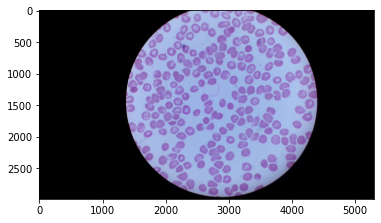

In [60]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 1)
plt.imshow(img)

In [61]:
# cv2.circle(img, df_file['position'][240][0], 1, (0,255,0), 50)
# plt.imshow(img)

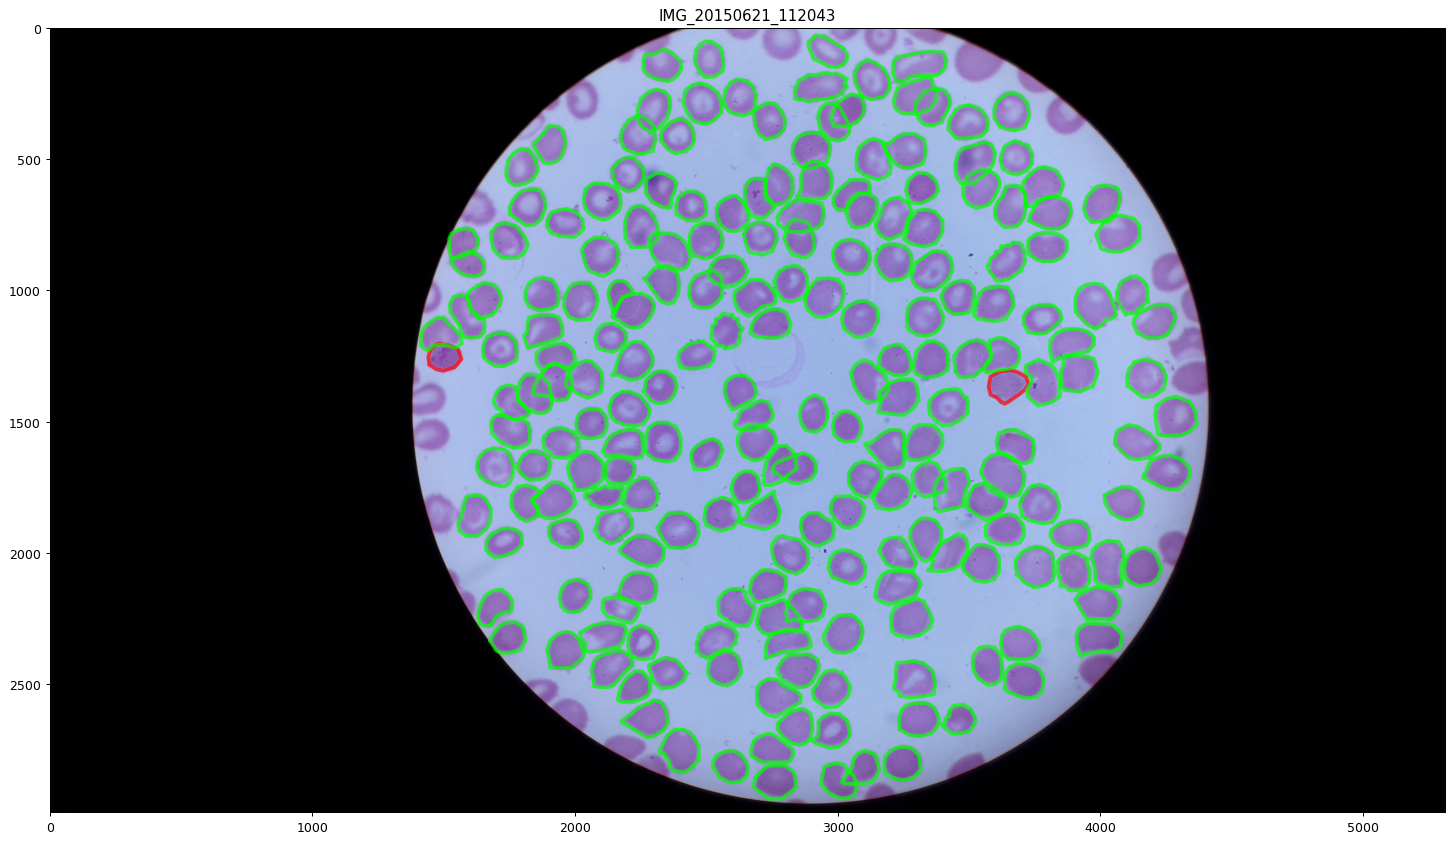

In [62]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)
plt.imshow(img)

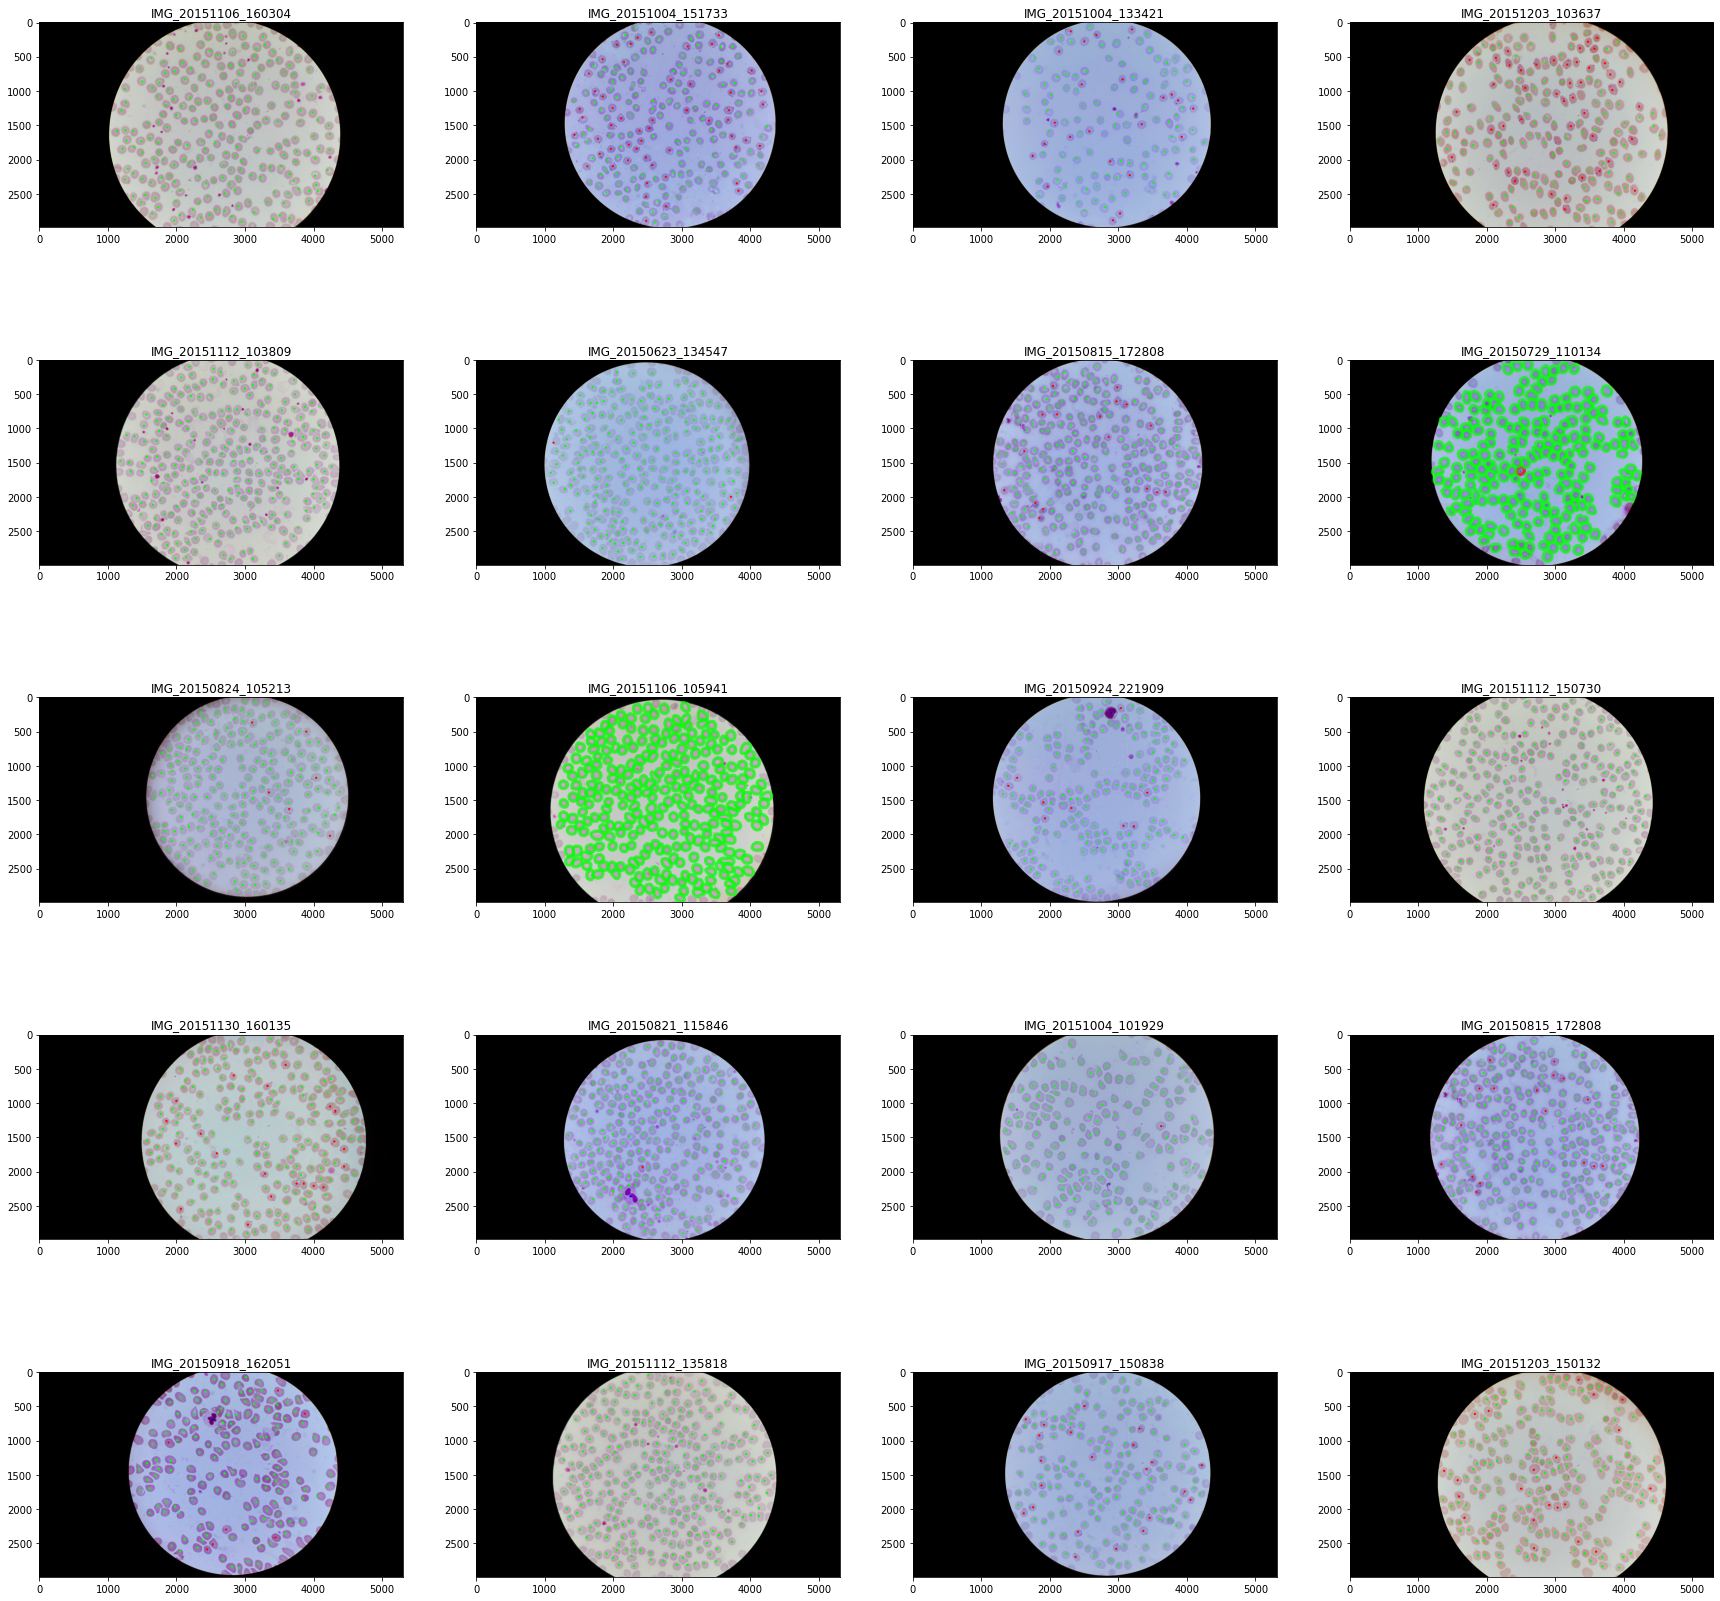

In [63]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Polygons to mask

In [64]:
def poly_mask(row):
    poly = Polygon(row['position'])
    mask = poly.ravel().tolist()

In [65]:
filename =  'IMG_20151029_162934'

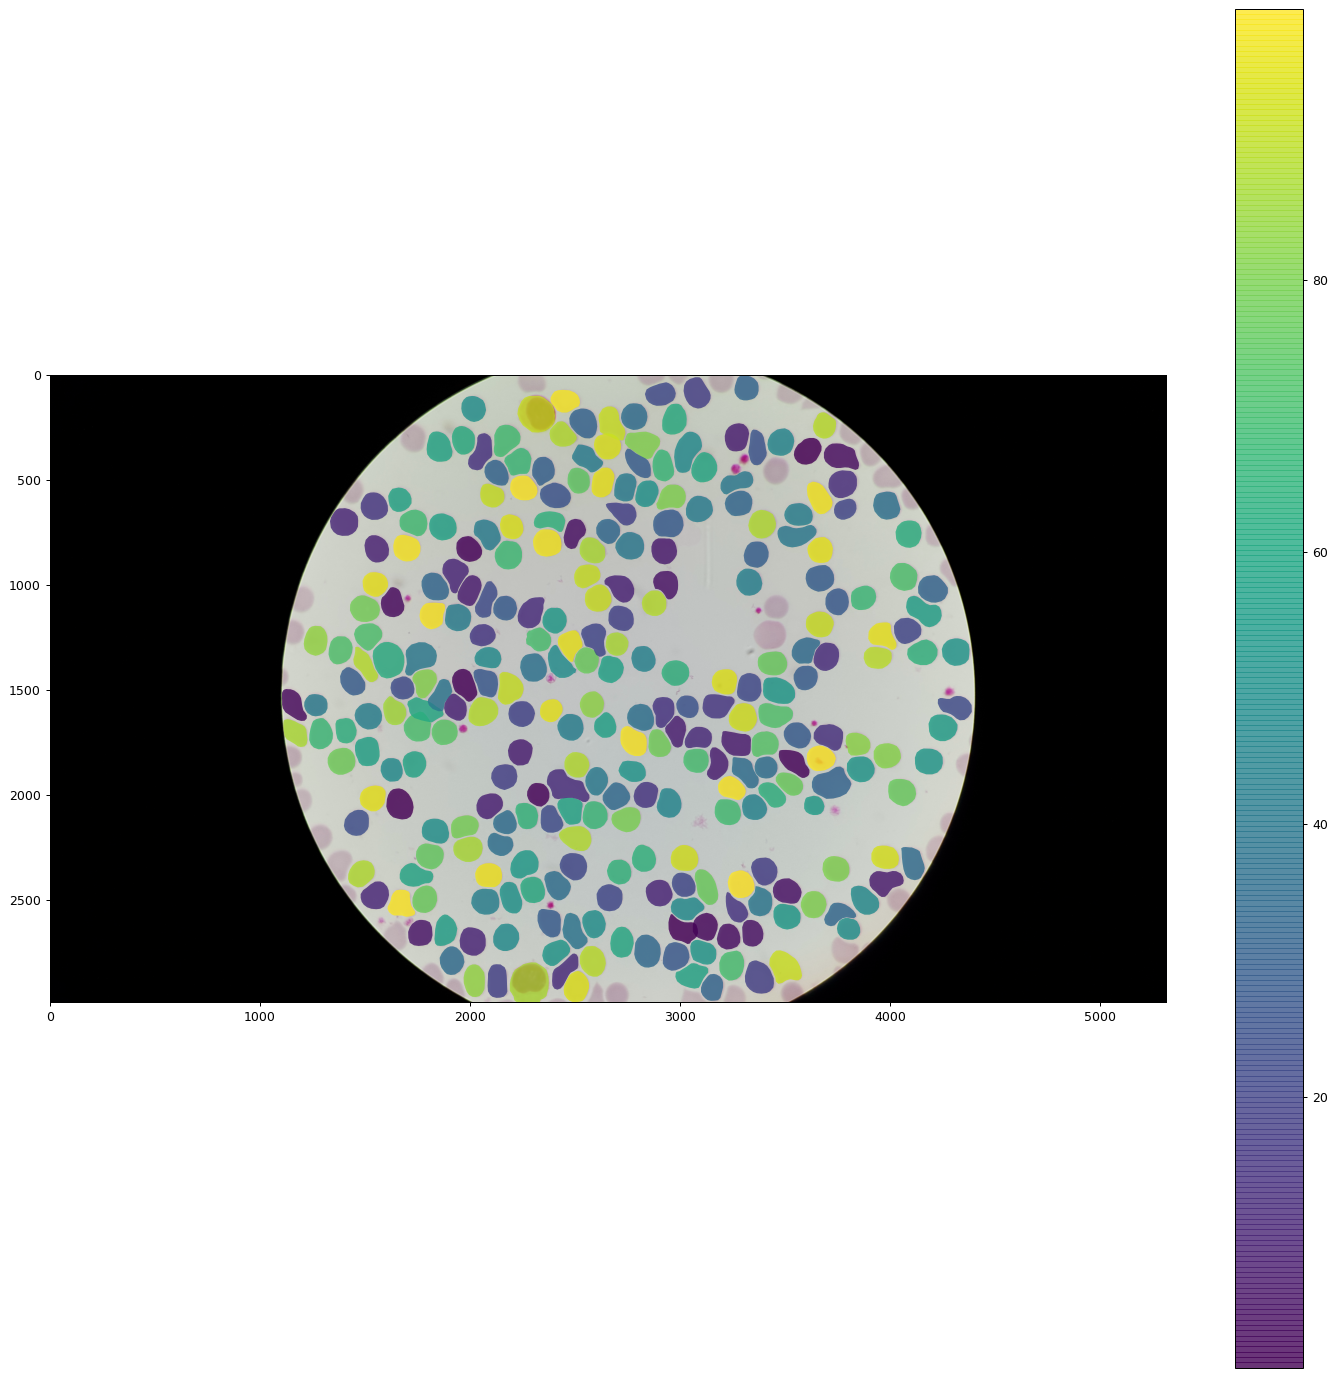

In [66]:
patches = []
patches = [ Polygon(poly) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position'] ]

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
empty_img = Image.new("L", [img.shape[1], img.shape[0]], 0)
mask = np.array(empty_img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.imshow(img)

image shape:  <PIL.Image.Image image mode=1 size=5312x2988 at 0x1539B1828>


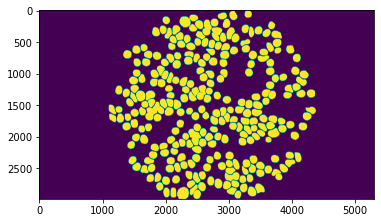

In [67]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)

img = Image.new("L", [img.shape[1], img.shape[0]], 0)
img = img.convert('1')
print('image shape: ', img)
[ ImageDraw.Draw(img).polygon(poly, outline=1, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)

plt.imshow(mask)

img.save('Images/polygon_mask.png')

In [68]:
def poly2mask(filename):
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
    img = Image.new("L", [img.shape[1], img.shape[0]], 0)
    img = img.convert('1')
    [ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
    # mask = np.array(img)
    # data = Image.fromarray(mask) 
    # # saving the final output  
    # # as a PNG file 
    # data = data.convert('1')
    # data.save(f'../masks/mask_{filename}.png')
    if not os.path.isdir('../masks'):
        os.makedirs('../masks')

    mask_path = f'../masks/mask_{filename}.png'
    img.save(mask_path)
    return mask, mask_path

In [69]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                             bbx  
195475  [3575, 1304, 3727, 1432]  
195476  [1441, 1202, 1568, 1307]  
195477  [2856, 1398, 2960, 1541]  
195478  [2982, 1460, 3091, 1578]  
195479  [3043, 1651, 3169, 1788]  
...                          ...  
195679  [3289, 1194, 3419, 1331]  
195680  [3346, 1375, 3496, 1515]  
195681  [3259, 1511, 3400, 1647]  
195682  [3104, 1

## Connected Components

In [70]:
def connected_component_label(img):
    # https://iq.opengenus.org/connected-component-labeling/
    # https://stackoverflow.com/questions/13572448/replace-values-of-a-numpy-index-array-with-values-of-a-list


    num_labels, labels = cv2.connectedComponents(img)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    palette = np.arange(1, 179)
    list_rand_nums = np.random.randint(1,179, 179)
    # list_rand_nums gives the new values you wish palette to be mapped to.
    index = np.digitize(label_hue.ravel(), palette, right=True)
    random_hue = np.uint8(list_rand_nums[index].reshape(label_hue.shape))

    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([random_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

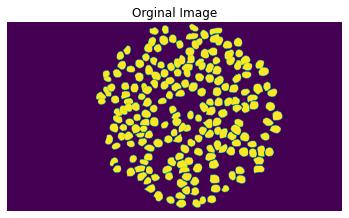

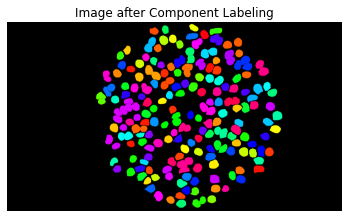

In [71]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
img = Image.new("L", [img.shape[1], img.shape[0]], 0)
#img = img.convert('1')
[ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)
connected_component_label(mask)

In [72]:
num_labels, labels = cv2.connectedComponents(mask)
print(len(labels[0]))
print(np.max(labels))

5312
175


In [73]:
df

Patient no - Cell no         cell     comment annotation_type  \
0                       1-1  Parasitized  No_Comment           Point   
1                       1-2   Uninfected  No_Comment           Point   
2                       1-3   Uninfected  No_Comment           Point   
3                       1-4   Uninfected  No_Comment           Point   
4                       1-5   Uninfected  No_Comment           Point   
...                     ...          ...         ...             ...   
196929                4-167  Parasitized  No_comment         Polygon   
196930                4-168  Parasitized  No_comment         Polygon   
196931                4-169  Parasitized  No_comment         Polygon   
196932                4-170  Parasitized  No_comment         Polygon   
196933                4-171  Parasitized  No_comment         Polygon   

       Number of points                                           position  \
0                     1                                     [(2470, 1302)]   
1                     1                                      [(1598, 944)]   
2                     1                                      [(1756, 987)]   
3                     1                                      [(2000, 895)]   
4                     1                                     [(1938, 1006)]   
...                 ...                                                ...   
196929               25  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930               21  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931               20  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932               20  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933               17  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                             bbx  
0       [2400, 1232, 2540, 1372]  
1        [1528, 874, 1668, 1014]  
2        [1686, 917, 1826, 1057]  
3         [1930, 825, 2070, 965]  
4        [1868, 936, 2008, 1076]  
...                          ...  
196929    [2389, 328, 2516, 490]  
196930  [3516, 2212, 3675, 2345]  
196931  [3318, 2086, 3469, 2235]  
196932  [3431, 1

In [74]:
def get_bbx(position, annotation_type, bb_pixel):
    if annotation_type == 'Polygon':
        poly_list = np.array([list(ele) for ele in position])
        x_min = np.nanmin(poly_list[:, 0])
        x_max = np.nanmax(poly_list[:, 0])
        y_min = np.nanmin(poly_list[:, 1])
        y_max = np.nanmax(poly_list[:, 1])
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Point':
        point_list = np.array(position)
        x_min = int(point_list[:, 0] - 0.5 * bb_pixel)
        x_max = int(point_list[:, 0] + 0.5 * bb_pixel)
        y_min = int(point_list[:, 1] - 0.5 * bb_pixel)
        y_max = int(point_list[:, 1] + 0.5 * bb_pixel)
        return [x_min, y_min, x_max, y_max]

In [75]:
df['bbx'] = df.apply(lambda row: get_bbx(row['position'], row['annotation_type'], 140), axis = 1)
df

Patient no - Cell no         cell     comment annotation_type  \
0                       1-1  Parasitized  No_Comment           Point   
1                       1-2   Uninfected  No_Comment           Point   
2                       1-3   Uninfected  No_Comment           Point   
3                       1-4   Uninfected  No_Comment           Point   
4                       1-5   Uninfected  No_Comment           Point   
...                     ...          ...         ...             ...   
196929                4-167  Parasitized  No_comment         Polygon   
196930                4-168  Parasitized  No_comment         Polygon   
196931                4-169  Parasitized  No_comment         Polygon   
196932                4-170  Parasitized  No_comment         Polygon   
196933                4-171  Parasitized  No_comment         Polygon   

       Number of points                                           position  \
0                     1                                     [(2470, 1302)]   
1                     1                                      [(1598, 944)]   
2                     1                                      [(1756, 987)]   
3                     1                                      [(2000, 895)]   
4                     1                                     [(1938, 1006)]   
...                 ...                                                ...   
196929               25  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930               21  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931               20  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932               20  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933               17  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                             bbx  
0       [2400, 1232, 2540, 1372]  
1        [1528, 874, 1668, 1014]  
2        [1686, 917, 1826, 1057]  
3         [1930, 825, 2070, 965]  
4        [1868, 936, 2008, 1076]  
...                          ...  
196929    [2389, 328, 2516, 490]  
196930  [3516, 2212, 3675, 2345]  
196931  [3318, 2086, 3469, 2235]  
196932  [3431, 1

## Tiling images and labels

(2988, 5312)


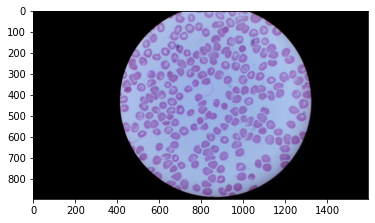

In [76]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
resize_factor = .3
print(img.shape[:2])
resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))), interpolation=cv2.INTER_AREA)
plt.imshow(resized_img)

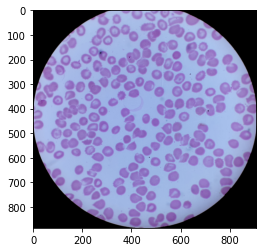

In [77]:
# select circle only
img_gray = rgb2gray(resized_img)
th = threshold_otsu(img_gray)
fg = img_gray>th
# Find the bounding box of those pixels
coords = np.array(np.nonzero(fg))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

#set all under threshhold values to zero 
img_circle = resized_img*gray2rgb(fg)

img_cropped = img_circle[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(img_cropped)

In [78]:
df_file

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                             bbx  
195475  [3575, 1304, 3727, 1432]  
195476  [1441, 1202, 1568, 1307]  
195477  [2856, 1398, 2960, 1541]  
195478  [2982, 1460, 3091, 1578]  
195479  [3043, 1651, 3169, 1788]  
...                          ...  
195679  [3289, 1194, 3419, 1331]  
195680  [3346, 1375, 3496, 1515]  
195681  [3259, 1511, 3400, 1647]  
195682  [3104, 1

In [79]:
def plot_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)

    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        #print(i)
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            #print(j)
            #print((offset[1]*i, min(offset[1]*i+tile_size[1], img_shape[0])), (offset[0]*j, min(offset[0]*j+tile_size[0], img_shape[1])))
            x_min = min(offset[1] * x + tile_size[1], img_shape[0])
            x_max = offset[1] * x
            y_min = min(offset[0] * y + tile_size[0], img_shape[1])
            y_max = offset[0]*y
            cv2.rectangle(img, (x_max, x_min), (y_max, y_min), (0, 0, 255), 3)
            #cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            # Debugging the tiles
            #cv2.imwrite("debug_" + str(i) + "_" + str(j) + ".png", cropped_img)
    plt.imshow(crop_img)

def crop_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)
    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            x_min = offset[1] * x
            x_max = min(offset[1] * x + tile_size[1], img_shape[0])
            y_min = offset[0]*y
            y_max = min(offset[0] * y + tile_size[0], img_shape[1])
            crop_image = img[x_min : x_min + tile_w, y_min: y_min + tile_h]
            cv2.imwrite(f'../cropped/{x_min}_{x_max}_{y_min}_{y_max}.png', crop_image) 
    #plt.imshow(crop_image)


In [80]:
crop_tiles(img_cropped, 256, 256)

In [81]:
def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [276]:
###############################################################################
def slice_img(input_im, input_mask, 
                     filename,
                    outdir_im, 
                     outdir_mask,
                     outdir_label,
                      classes_dic, 
                     category, 
                     box_coords, resize_factor = 1,
                  sliceHeight=256, sliceWidth=256,
                  zero_frac_thresh=0, overlap=0, pad=0, verbose=False,
                  box_coords_dir='', yolt_coords_dir=''):
    '''
    ADAPTED FROM YOLT/SCRIPTS/SLICE_IM.PY
    Assume input_im is rgb
    Slice large image into smaller pieces,
    ignore slices with a percentage null greater then zero_fract_thresh'''

    print('############# slice_img #############')
    img = cv2.imread(input_im, 1)  # color
    mask = cv2.imread(input_mask, 0)
    category_num = [classes_dic[k] for k in category] 

    resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))))
    resized_mask = cv2.resize(mask, (int(round(mask.shape[1] * resize_factor)), int(round(mask.shape[0] * resize_factor))))
    resized_box_coords = np.array(np.round(np.array(box_coords) * np.array(resize_factor)).astype(int))


    im_h, im_w = resized_img.shape[:2]
    print('im_h', im_h)
    print('im_w', im_w)

    win_size = sliceHeight*sliceWidth

    # if slice sizes are large than image, pad the edges
    if sliceHeight > im_h:
        pad = sliceHeight - im_h
    if sliceWidth > im_w:
        pad = max(pad, sliceWidth - im_w)
    # pad the edge of the image with black pixels
    if pad > 0:
        border_color = (0, 0, 0)
        resized_img = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                   cv2.BORDER_CONSTANT, value=border_color)
        resized_mask = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                            cv2.BORDER_CONSTANT, value=border_color)

    t0 = time.time()
    n_ims = 0
    n_ims_nonull = 0
    dx = int((1. - overlap) * sliceWidth)
    dy = int((1. - overlap) * sliceHeight)
    print('dx', dx)
    print('dy', dy)
    dict_yolo = {}
    dict_bbx = {}
    cut_imgs_name = []
    max_annot = 0
    bboxes = []
    

    for y in range(0, im_h, dy):  # sliceHeight):
        for x in range(0, im_w, dx):  # sliceWidth):
            n_ims += 1
            # extract image
            # make sure we don't go past the edge of the image
            if y + sliceHeight > im_h:
                y0 = im_h - sliceHeight
            else:
                y0 = y
            if x + sliceWidth > im_w:
                x0 = im_w - sliceWidth
            else:
                x0 = x

            window_c = resized_img[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            window_mask = resized_mask[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
##           gt_c = gt_image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
#             gt_c = image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            win_h, win_w = window_c.shape[:2]
    
            outname_part = 'slice_' + filename + \
            '_' + str(y0) + '_' + str(x0) + \
            '_' + str(win_h) + '_' + str(win_w) + \
            '_' + str(pad)

            outname_mask_part = 'slice_mask_' + filename + \
            '_' + str(y0) + '_' + str(x0) + \
            '_' + str(win_h) + '_' + str(win_w) + \
            '_' + str(pad)
    
            # [x0, x1, y0, y1]


            # get black and white image
            window = cv2.cvtColor(window_c, cv2.COLOR_BGR2GRAY)

            # find threshold of image that's not black
            # https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html?highlight=threshold
            ret, thresh1 = cv2.threshold(window, 2, 255, cv2.THRESH_BINARY)
            non_zero_counts = cv2.countNonZero(thresh1)
            zero_counts = win_size - non_zero_counts
            zero_frac = float(zero_counts) / win_size
            # print ("zero_frac", zero_fra
            # skip if image is mostly empty
            if zero_frac >= zero_frac_thresh:
                if verbose:
                    print("Zero frac too high at:", zero_frac)
                continue
                
            new_box_coords = []
            yolt_coords = []
            annot_count = 0

            #for box in resized_box_coords: 
            for box, cat in zip(resized_box_coords, category_num):
                if box[0] >= x0 and box[2] <= x0 + sliceHeight and box[1] >= y0 and box[3] <= y0 + sliceHeight:
                    box = np.asarray([box[0] - x0, box[1] - y0, box[2] - x0, box[3] - y0, cat])
                    new_box_coords.append(box)
                    annot_count += 1
                    # Input to convert: image size: (w,h), box: [x0, x1, y0, y1]
                    #print(box)
                    yolt_co_i = convert((win_w, win_h), box)
                    yolt_coords.append(yolt_co_i)
            
            if annot_count > max_annot:
                max_annot = annot_count

            #  save
            outname_im = os.path.join(outdir_im, outname_part + '.png')
            outname_mask = os.path.join(outdir_mask, outname_mask_part + '.png')
            txt_outpath = os.path.join(outdir_label, outname_part + '.txt')

            dict_yolo[outname_im] = yolt_coords
            dict_bbx[outname_im] = new_box_coords
            cut_imgs_name.append(outname_im)
            bboxes.append(np.asarray(new_box_coords))

            # save yolt ims
            if verbose:
                print("image output:", outname_im)
            cv2.imwrite(outname_im, window_c)
            cv2.imwrite(outname_mask, window_mask)

            # save yolt labels
            txt_outfile = open(txt_outpath, "w+")
            if verbose:
                print("txt output:" + txt_outpath)
            for bb in yolt_coords:
                outstring = str(category_num) + " " + \
                    " ".join([str(a) for a in bb]) + '\n'
                if verbose:
                    print("outstring:", outstring)
                txt_outfile.write(outstring)
            txt_outfile.close()

            # if desired, save coords files
            # save box coords dictionary so that yolt_eval.py can read it
            if len(box_coords_dir) > 0:
                coords_dic = gt_dic_from_box_coords(box_coords)
                outname_pkl = os.path.join(
                    box_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(coords_dic, open(outname_pkl, 'wb'), protocol=2)
            if len(yolt_coords_dir) > 0:
                outname_pkl = os.path.join(
                    yolt_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(yolt_coords, open(outname_pkl, 'wb'), protocol=2)

            n_ims_nonull += 1


    print("Num slices:", n_ims, "Num non-null slices:", n_ims_nonull,
          "sliceHeight", sliceHeight, "sliceWidth", sliceWidth)
    print("Time to slice", input_im, time.time()-t0, "seconds")

    return dict_yolo, dict_bbx, bboxes, cut_imgs_name, max_annot

def convert(size, box):
    '''Input = image size: (w,h), box: [x0, x1, y0, y1]'''
    dw = 1./size[0]
    dh = 1./size[1]
    xmid = (box[0] + box[1])/2.0
    ymid = (box[2] + box[3])/2.0
    w0 = box[1] - box[0]
    h0 = box[3] - box[2]
    x = xmid*dw
    y = ymid*dh
    w = w0*dw
    h = h0*dh
    return (x, y, w, h)

In [292]:
dict_mask = {}
dict_bbxs = {}
total_max_annot = 0
imgs_name = []
annots = np.array([])
for filename in df.loc[(df['annotation_type'] == 'Polygon'), 'filename'].unique():
    # first we create a black and white mask where the polygons are white
    print(filename)
    mask, mask_path = poly2mask(filename)
    dict_mask[filename] = mask_path
    print(mask_path)
    # now lets slice the images (and bbx although we will proabaly not use them)
    filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
    img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]
    
    if not os.path.isdir('../cropped'):
        os.makedirs('../cropped')


    outdir_im = f'../cropped/{filename}/img'
    outdir_mask = f'../cropped/{filename}/mask'
    outdir_label = f'../cropped/{filename}/labels'
    check_if_outdir_im = os.path.isdir(outdir_im)
    check_if_outdir_mask = os.path.isdir(outdir_mask)
    check_if_outdir_label = os.path.isdir(outdir_label)


    if not check_if_outdir_im:
        os.makedirs(outdir_im)
    if not check_if_outdir_mask:
        os.makedirs(outdir_mask)
    if not check_if_outdir_label:
        os.makedirs(outdir_label)

    slice_height = 256
    slice_width = 256
    resize_factor = 0.3
    classes_dic = {'Uninfected': 0, 'Parasitized': 1, 'White_Blood_Cell': 2}
    box_coords = df.loc[(df['filename'] == filename),'bbx'].tolist()
    category = df.loc[(df['filename'] == filename),'cell'].tolist()

    dict_yolo, dict_bbx, \
    bboxes, cut_imgs_name, \
        max_annot = slice_img(img_path, mask_path, 
                            filename,
                            outdir_im, 
                            outdir_mask, 
                            outdir_label,
                            classes_dic, 
                            category, 
                            box_coords, 
                        sliceHeight= slice_height, sliceWidth=slice_width,
                        resize_factor = resize_factor,
                        zero_frac_thresh=0.9, overlap=0, pad=0, verbose=False,
                        box_coords_dir='', yolt_coords_dir='')

    if max_annot > total_max_annot:
        total_max_annot = max_annot

    dict_bbxs.update(dict_bbx)
    annots = np.append(annots, bboxes)
    imgs_name += cut_imgs_name


2_145330.jpg 0.07782196998596191 seconds
IMG_20151002_144855
../masks/mask_IMG_20151002_144855.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/270C122P83ThinF/Img/IMG_20151002_144855.jpg 0.06036806106567383 seconds
IMG_20150817_103139
../masks/mask_IMG_20150817_103139.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/221C79P40ThinF/Img/IMG_20150817_103139.jpg 0.06377601623535156 seconds
IMG_20150817_103303
../masks/mask_IMG_20150817_103303.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/221C79P40ThinF/Img/IMG_20150817_103303.jpg 0.061584949

In [293]:
df['mask_path'] = df['filename'].map(dict_mask)

In [294]:
imgs_name[0]

'../cropped/IMG_20151106_112252/img/slice_IMG_20151106_112252_0_256_256_256_0.png'

In [299]:
annots[0]

array([[206, 122, 238, 164,   0]])

In [300]:
len(annots[1])

16

In [301]:
dict_bbxs[imgs_name[0]]

[array([206, 122, 238, 164,   0])]

In [298]:
imgs_name = np.array(imgs_name)
true_boxes = np.zeros((imgs_name.shape[0], total_max_annot, 5))
print('imgs_name.shape: ', imgs_name.shape)
print('max_annot: ', max_annot)
print('len annots: ', len(annots))
print('true_boxes shape: ', true_boxes.shape)
for idx, boxes in enumerate(annots):
    #print('boxes: ', boxes)
    print('boxes shape: ', boxes.shape)
    print('idx: ', idx)
    if len(boxes) == 0:
        boxes = np.asarray([0,0,0,0,0])
    true_boxes[idx, :boxes.shape[0], :5] = boxes

boxes shape:  (2, 5)
idx:  2003
boxes shape:  (3, 5)
idx:  2004
boxes shape:  (20, 5)
idx:  2005
boxes shape:  (21, 5)
idx:  2006
boxes shape:  (12, 5)
idx:  2007
boxes shape:  (2, 5)
idx:  2008
boxes shape:  (15, 5)
idx:  2009
boxes shape:  (20, 5)
idx:  2010
boxes shape:  (10, 5)
idx:  2011
boxes shape:  (12, 5)
idx:  2012
boxes shape:  (20, 5)
idx:  2013
boxes shape:  (14, 5)
idx:  2014
boxes shape:  (6, 5)
idx:  2015
boxes shape:  (18, 5)
idx:  2016
boxes shape:  (19, 5)
idx:  2017
boxes shape:  (18, 5)
idx:  2018
boxes shape:  (2, 5)
idx:  2019
boxes shape:  (1, 5)
idx:  2020
boxes shape:  (19, 5)
idx:  2021
boxes shape:  (22, 5)
idx:  2022
boxes shape:  (16, 5)
idx:  2023
boxes shape:  (1, 5)
idx:  2024
boxes shape:  (18, 5)
idx:  2025
boxes shape:  (24, 5)
idx:  2026
boxes shape:  (12, 5)
idx:  2027
boxes shape:  (12, 5)
idx:  2028
boxes shape:  (14, 5)
idx:  2029
boxes shape:  (10, 5)
idx:  2030
boxes shape:  (5, 5)
idx:  2031
boxes shape:  (23, 5)
idx:  2032
boxes shape:  (20,

In [302]:
len(dict_bbxs)

2619

In [303]:
with open('imgs_name.pickle', 'wb') as handle:
    pickle.dump(imgs_name, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('true_boxes.pickle', 'wb') as handle:
    pickle.dump(true_boxes, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Polygon to rectangle

In [50]:
filename =  'IMG_20150621_112043'
df_file = df[df['filename'] == filename]
df_file['position'].iloc[-1]

[(4166, 1704),
 (4176, 1688),
 (4184, 1664),
 (4195, 1647),
 (4230, 1633),
 (4272, 1631),
 (4309, 1644),
 (4342, 1679),
 (4341, 1709),
 (4326, 1733),
 (4299, 1758),
 (4265, 1758),
 (4233, 1750),
 (4204, 1735),
 (4174, 1718),
 (4162, 1714)]

In [51]:
rect = df_file['bbx']

In [52]:
rect

195475    [3575, 1304, 3727, 1432]
195476    [1441, 1202, 1568, 1307]
195477    [2856, 1398, 2960, 1541]
195478    [2982, 1460, 3091, 1578]
195479    [3043, 1651, 3169, 1788]
                    ...           
195679    [3289, 1194, 3419, 1331]
195680    [3346, 1375, 3496, 1515]
195681    [3259, 1511, 3400, 1647]
195682    [3104, 1532, 3255, 1679]
195683    [4162, 1631, 4342, 1758]
Name: bbx, Length: 209, dtype: object

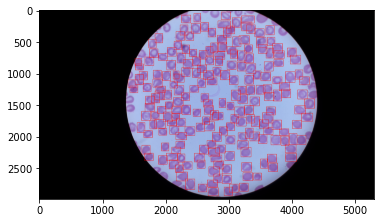

In [111]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)

In [49]:
img = cv2.imread( '../train/IMG_20150724_102843/img/slice_IMG_20150724_102843_0_512_256_256_0.png', cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)

KeyError: 'bbx'